# Chapter 9 - More Regression Methods



In [2]:
# setup
from mlwpy import *
%matplotlib inline

diabetes = datasets.load_diabetes()

d_tts = skms.train_test_split(diabetes.data,
                              diabetes.target,
                              test_size=.25,
                              random_state=42)

(diabetes_train_ftrs, diabetes_test_ftrs,
 diabetes_train_tgt, diabetes_test_tgt) = d_tts

We dive into a few additional techniques for regression.  All are variations on techniques we've seen before.   Two are direct variations on linear regression, one splices a support vector classifier with linear regression to create a Support Vector Regressor, and one uses decision trees for regression instead of classification.

Much of what we talk about will be famililar.

Also, we dicuss how to build a learner of plugs into `sklearn`'s usage patterns.

# 9.1 Linear Regression in the Penalty Box: Regularization

We can conceptually define the goodness of a model as a cost with two parts: (1) what we lose, or spend, when we make a mistake and (2) what we invest, or spend, into the model's complexity.  

The math says the: *cost = loss(errors) + complexity*.  

Keeping mistakes low keeps us accurate.  Keeping complexity low, we keep the model simple and improve our ability to generalize.  

Overfitting has a high complexity and low training loss.  Underfitting has low complexity and high training loss and improve our ability to generalize.  The sweet spot is just the right amount of complexity and get a low loss on training *and* testing.

Keeping the complexity low and the model simple is called *regularization*.  Overfitting describes graphs as being too squiggly.  They overfit and follow noise instead of the pattern.  If we reduce some squiggliness, we do a better job of following the signal--the interesting pattern--and ignore the noise.

In [4]:
weights = np.array([3.5, -2.1, .7])
print(np.sum(np.abs(weights)),
      np.sum(weights**2))

6.3 17.15


Now, let's define some criteria for *relatively small*.  We want to simplify our model to move from overfitting and towards *just right*.  However, our just-right values cannot operate on their own, in a vaccuum.  They must be connected to how well we fit the data, we just want to tone down the *over* part of *overfitting.  Let's return to how we account for the quality of our fit.  Let's investigate a bit of data where we specifically control the errors in it:

In [58]:
x_1 = np.arange(10)
x_1

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [59]:
m, b = 3, 2
w = np.array([m, b])
w

array([3, 2])

In [60]:
x = np.c_[x_1, np.repeat(1.0, 10)] # the plus-one trick
x

array([[0., 1.],
       [1., 1.],
       [2., 1.],
       [3., 1.],
       [4., 1.],
       [5., 1.],
       [6., 1.],
       [7., 1.],
       [8., 1.],
       [9., 1.]])

In [61]:
errors = np.tile(np.array([0.0, 1.0, 1.0, .5, .5]),2)
errors

array([0. , 1. , 1. , 0.5, 0.5, 0. , 1. , 1. , 0.5, 0.5])

In [16]:
print(errors * errors)
print(np.dot(errors, errors))

[0.   1.   1.   0.25 0.25 0.   1.   1.   0.25 0.25]
5.0


In [24]:
y_true = rdot(w,x)
y_true

array([ 2.,  5.,  8., 11., 14., 17., 20., 23., 26., 29.])

In [25]:
y_msr = y_true + errors
y_msr

array([ 2. ,  6. ,  9. , 11.5, 14.5, 17. , 21. , 24. , 26.5, 29.5])

In [26]:
D = (x,y_msr)
D

(array([[0., 1.],
        [1., 1.],
        [2., 1.],
        [3., 1.],
        [4., 1.],
        [5., 1.],
        [6., 1.],
        [7., 1.],
        [8., 1.],
        [9., 1.]]),
 array([ 2. ,  6. ,  9. , 11.5, 14.5, 17. , 21. , 24. , 26.5, 29.5]))

Here's how the truth compares to our noise data points:

In [27]:
print(x_1)
print(y_true)
print(x_1)
print(y_msr)

[0 1 2 3 4 5 6 7 8 9]
[ 2.  5.  8. 11. 14. 17. 20. 23. 26. 29.]
[0 1 2 3 4 5 6 7 8 9]
[ 2.   6.   9.  11.5 14.5 17.  21.  24.  26.5 29.5]


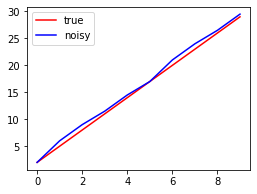

In [22]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(x_1, y_true, 'r', label='true')
ax.plot(x_1, y_msr, 'b', label='noisy')
ax.legend()

Now let's take a shortcut.  We are not going to go through the process of fitting and finding good parameters from the data.  We're not going to rerun a linear regression to pull out *w*s (or {*m, b*}). But let's imagine that we did and got back the perfect parameter values--the ones we used to *create* the data above.  Here's what our sum of squared errors look like:

In [28]:
def sq_diff(a,b):
    return (a-b)**2

In [29]:
predictions = rdot(w,x)
predictions

array([ 2.,  5.,  8., 11., 14., 17., 20., 23., 26., 29.])

In [30]:
np.sum(sq_diff(predictions, y_msr))

5.0

In [31]:
y_msr

array([ 2. ,  6. ,  9. , 11.5, 14.5, 17. , 21. , 24. , 26.5, 29.5])

That comes from this equation:

$ loss = \Sigma_{x,y \in D} (wx - y)^2 $

We need to account for ideas about keeping the weights small. This constraint is a surrogate for simplifying--regularizing--the model.  Let's say that instead of just making *predictions* we have a total *cost* associated with the model. 

In [38]:
predictions = rdot(w,x)
predictions

array([ 2.,  5.,  8., 11., 14., 17., 20., 23., 26., 29.])

In [37]:
loss = np.sum(sq_diff(predictions, y_msr))
loss

5.0

In [43]:
weights

array([ 3.5, -2.1,  0.7])

In [41]:
complexity_1 = np.sum(np.abs(weights))
complexity_1

6.3

In [42]:
complexity_2 = np.sum(weights**2) # == np.dot(weights, weights)
complexity_2

17.15

In [40]:
cost_1 = loss + complexity_1
cost_2 = loss + complexity_2

In [45]:
print('Sum(abs) complexity:', cost_1)
print('Sum(sqr) complexity:', cost_2)

Sum(abs) complexity: 11.3
Sum(sqr) complexity: 22.15


Remember, we performed a couple of tricks here.  We did not actually work from the data *back to* the weights. We just used the same weighst to make the data and to make our not-quite-predictions.  The second trick is that we used the *same weights* in both cases, so we have *same losses* contributing to both costs.  We cannot compare these two: normally, we would use one or the other to *compute the cost* which helps us find a good set of weights under one calculation for loss and complexity.

There's one last piece to introduce before showing a fundamental relatoinship of learning.  Once we define a cost and say that we want to have a low cost, we are really making another tradeoff.  We can lower the cost by making fewer errors: leading to a lower loss *or* by having less complexity.  Can we do both equally or do we consider one more important? Is cutting the complexity worth doubling the errors we make? Our *real goal* is to make few errors in the future, which happens by making fewer errors now--on training data--*and* by keeping the model complexity down.

To this end, it's valuable to add a way to trade off towards fewer errors or towards lower complexity and we do this like this:

In [54]:
predictions = rdot(w,x)
errors = np.sum(sq_diff(predictions, y_msr))
complexity_1 = np.sum(np.abs(weights))

In [53]:
predictions

array([ 2.,  5.,  8., 11., 14., 17., 20., 23., 26., 29.])

In [51]:
errors

5.0

In [52]:
complexity_1

6.3

In [49]:
C = .5
cost = errors + C * complexity_1
cost

8.15

AS far as cost is concerned, one point of increase in complexity is worth $ \frac{1}{2} $ of a point increase in loss.  That is, losses are twice as costly, or twice as important, as complexity.  If we use *C* to represent that tradeoff, we get the following math-heavy equations:

$$ Cost_{1} = \Sigma_{x,y \in D} (wx - y)^2 + C \Sigma_{j}\mid w_{j} \mid$$

$$ Cost_2 = \Sigma_{x,y \in D}(wx - y) ^ 2 + C \Sigma_{j}w_{j}^2 $$

Finding the best line with $ Cost_1 $ is called $ L_1$-regularized regression, or the *lasso*.  Finding the best line with $ Cost_2 $ is called the $ L_2$-regularized regression, or *ridge regression*. 

### 9.1.1 Performing Regularized Regression

Performing regularized linear regression is no more difficult than the good old-fashion (DOF) linear regression.

The default value for our *C*, a total weight of the complexity penalty, is `1.0` for both `Lasso` and `Ridge`.  In `sklearn`, the *C* value is set by the parameter `alpha`.  So, for *C* = 2, we would call `linear_model.Lasso(alpha=2.0)`.  You see $\lambda, \alpha$, and *C* in discussions of regularization; 

they all serve a similar role, but you do have to apy attention for authors using slight variations in meaning.  For our purposes, we consider them all the same.

In [56]:
models = [linear_model.Lasso(),         # L1 regularized; C=1.0
          linear_model.Ridge()]         # L2 regularized; C=1.0

for model in models:
    model.fit(diabetes_train_ftrs, diabetes_train_tgt)
    train_preds = model.predict(diabetes_train_ftrs)
    test_preds  = model.predict(diabetes_test_ftrs)
    print(get_model_name(model),
         '\nTrain MSE:', metrics.mean_squared_error(diabetes_train_tgt,
                                                    train_preds),
         '\n Test MSE:', metrics.mean_squared_error(diabetes_test_tgt,
                                                    test_preds))

Lasso 
Train MSE: 3947.899897977697 
 Test MSE: 3433.1524588051197
Ridge 
Train MSE: 3461.739515097773 
 Test MSE: 3105.468750907886


Using these is so easy, we might move on without *thinking* about when and why to use them.  The default of linear regression is to operatie *without* regularization.

We can easily switch to a regularized version and see if it improves matters.  We might try this when we train on some data and see an overfitting failure.  Next, we can try different amounts of regularization -- different values for *C* -- and see what works best on cross-validated runs.

With very noisy data, we might be tempted to make a complex model that is likely to overfit.  We have to *tolerate* a fair bit of error in the model to reduce our complexity.  In other words, we pay less for complexity and pay more for errors.  

With data that is noiseless and captures a linear pattern, on the other hand, we have little need for controling complexity and should see good results with GOF linear regression.



# 9.2 Support Vector Regression

The cost comes from both the mistakes (errors) and the complexity of our learner.  Support Vector Regression (SVR) makes use of thsi in a same-but different manner.  

We regularized GOF linear regression by adding a complexity factor to its loss.  We can continue down this path and tweak linear regression even more.  We can modify its loss also.  Remember $ cost = loss + complexity. $  In linear regression, the standard loss is the sum of squared errors called the *squared error loss*.  As we just saw in the definitions above, that form is called $ L_2. $  In that case, $ L_2 $ is the loss.  You might be thinking, let's use $ L_1 $ the sum of absolute values.  We are going to use $L_1$, but tweak it.. Our tweaked $ L_1 $ ignores small errors.

## 9.2.1 Hinge Loss

Regarding Support Vector Classifiers (SVCs), we did not discuss the underlying magic that lets a SVC do its tricks.  The magic is very similar for the SVC and SVR: both make use of a slightly different loss than linear regression (either kind).  Basically, we want to measure what happens when we are *wrong* and ignore small errors.  If we put these two pieces of information together, we get the *hinge loss*.  Here's what the absolute values of the errors look like: 

In [62]:
error = np.linspace(-4, 4, 100)
error

array([-4.    , -3.9192, -3.8384, -3.7576, -3.6768, -3.596 , -3.5152,
       -3.4343, -3.3535, -3.2727, -3.1919, -3.1111, -3.0303, -2.9495,
       -2.8687, -2.7879, -2.7071, -2.6263, -2.5455, -2.4646, -2.3838,
       -2.303 , -2.2222, -2.1414, -2.0606, -1.9798, -1.899 , -1.8182,
       -1.7374, -1.6566, -1.5758, -1.4949, -1.4141, -1.3333, -1.2525,
       -1.1717, -1.0909, -1.0101, -0.9293, -0.8485, -0.7677, -0.6869,
       -0.6061, -0.5253, -0.4444, -0.3636, -0.2828, -0.202 , -0.1212,
       -0.0404,  0.0404,  0.1212,  0.202 ,  0.2828,  0.3636,  0.4444,
        0.5253,  0.6061,  0.6869,  0.7677,  0.8485,  0.9293,  1.0101,
        1.0909,  1.1717,  1.2525,  1.3333,  1.4141,  1.4949,  1.5758,
        1.6566,  1.7374,  1.8182,  1.899 ,  1.9798,  2.0606,  2.1414,
        2.2222,  2.303 ,  2.3838,  2.4646,  2.5455,  2.6263,  2.7071,
        2.7879,  2.8687,  2.9495,  3.0303,  3.1111,  3.1919,  3.2727,
        3.3535,  3.4343,  3.5152,  3.596 ,  3.6768,  3.7576,  3.8384,
        3.9192,  4. 

In [65]:
loss = np.abs(error)
loss

array([4.    , 3.9192, 3.8384, 3.7576, 3.6768, 3.596 , 3.5152, 3.4343,
       3.3535, 3.2727, 3.1919, 3.1111, 3.0303, 2.9495, 2.8687, 2.7879,
       2.7071, 2.6263, 2.5455, 2.4646, 2.3838, 2.303 , 2.2222, 2.1414,
       2.0606, 1.9798, 1.899 , 1.8182, 1.7374, 1.6566, 1.5758, 1.4949,
       1.4141, 1.3333, 1.2525, 1.1717, 1.0909, 1.0101, 0.9293, 0.8485,
       0.7677, 0.6869, 0.6061, 0.5253, 0.4444, 0.3636, 0.2828, 0.202 ,
       0.1212, 0.0404, 0.0404, 0.1212, 0.202 , 0.2828, 0.3636, 0.4444,
       0.5253, 0.6061, 0.6869, 0.7677, 0.8485, 0.9293, 1.0101, 1.0909,
       1.1717, 1.2525, 1.3333, 1.4141, 1.4949, 1.5758, 1.6566, 1.7374,
       1.8182, 1.899 , 1.9798, 2.0606, 2.1414, 2.2222, 2.303 , 2.3838,
       2.4646, 2.5455, 2.6263, 2.7071, 2.7879, 2.8687, 2.9495, 3.0303,
       3.1111, 3.1919, 3.2727, 3.3535, 3.4343, 3.5152, 3.596 , 3.6768,
       3.7576, 3.8384, 3.9192, 4.    ])

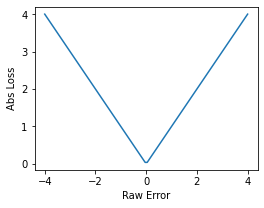

In [63]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(error, loss)

ax.set_xlabel('Raw Error')
ax.set_ylabel('Abs Loss');

How can we ignore errors up to a certain threshold? For example, let's write code that ignores absolute errors that are less than 1.0:

In [67]:
an_error = .75
abs_error = abs(an_error)
if abs_error < 1.0:
    the_loss = 0.0
else:
    the_loss = abs_error
print(the_loss)

0.0


Now, we will re-write the above with some clever mathematics. 

1. Subtract the threshold value from the absolute error.
2. If the result is bigger than zero, keep it.  Otherwise, take zero instead.

In [70]:
an_error = .75
adj_error = abs(an_error) - 1.0
if adj_error < 0.0:
    the_loss = 0.0
else:
    the_loss = adj_error
print(the_loss)

0.0


If we want to further condense this into a single mathematical expression we can consider that `if adj_error < 0.0`, we get `0`.  If `adj_error >= 0.0`, we get `adj_error`, and realize that those two outcomes are the same as taking the bigger value of `adj_error` or `0`.  

Text(0, 0.5, 'Hinge Loss')

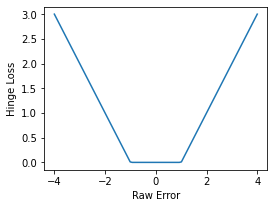

In [71]:
error = np.linspace(-4, 4, 100)

# here, we ignore errors up to 1.0 by taking bigger value
loss = np.maximum(np.abs(error) - 1.0,
                  np.zeros_like(error))

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(error, loss)

ax.set_xlabel('Raw Error')
ax.set_ylabel('Hinge Loss')

Mathematically we can encode the **hinge loss** as the *loss* = max(|*error*| - *threshold*, 0). First, subtract the amount of error we are willing to ignore from the raw error. If we have a negative value, then maxing against zero will throw it out.  For example, if we have an absolute error of .5 (from a raw error of .5 or -5) and we subtract 1, we end up with an adjusted error of -1.5.  Maxing with 0, we take the 0.  We are left with zero--no cost.  

The *hinge loss* get its name because the above graph looks like a pair of doors with hinges at the kinks or corners.  When we apply the hinge loss around a known target, we get a band where we don't care about small differences.

In [72]:
threshold = 2.5

xs = np.linspace(-5,5,100)
xs

array([-5.    , -4.899 , -4.798 , -4.697 , -4.596 , -4.4949, -4.3939,
       -4.2929, -4.1919, -4.0909, -3.9899, -3.8889, -3.7879, -3.6869,
       -3.5859, -3.4848, -3.3838, -3.2828, -3.1818, -3.0808, -2.9798,
       -2.8788, -2.7778, -2.6768, -2.5758, -2.4747, -2.3737, -2.2727,
       -2.1717, -2.0707, -1.9697, -1.8687, -1.7677, -1.6667, -1.5657,
       -1.4646, -1.3636, -1.2626, -1.1616, -1.0606, -0.9596, -0.8586,
       -0.7576, -0.6566, -0.5556, -0.4545, -0.3535, -0.2525, -0.1515,
       -0.0505,  0.0505,  0.1515,  0.2525,  0.3535,  0.4545,  0.5556,
        0.6566,  0.7576,  0.8586,  0.9596,  1.0606,  1.1616,  1.2626,
        1.3636,  1.4646,  1.5657,  1.6667,  1.7677,  1.8687,  1.9697,
        2.0707,  2.1717,  2.2727,  2.3737,  2.4747,  2.5758,  2.6768,
        2.7778,  2.8788,  2.9798,  3.0808,  3.1818,  3.2828,  3.3838,
        3.4848,  3.5859,  3.6869,  3.7879,  3.8889,  3.9899,  4.0909,
        4.1919,  4.2929,  4.3939,  4.4949,  4.596 ,  4.697 ,  4.798 ,
        4.899 ,  5. 

In [74]:
ys_true = 3 * xs + 2
ys_true

array([-13.    , -12.697 , -12.3939, -12.0909, -11.7879, -11.4848,
       -11.1818, -10.8788, -10.5758, -10.2727,  -9.9697,  -9.6667,
        -9.3636,  -9.0606,  -8.7576,  -8.4545,  -8.1515,  -7.8485,
        -7.5455,  -7.2424,  -6.9394,  -6.6364,  -6.3333,  -6.0303,
        -5.7273,  -5.4242,  -5.1212,  -4.8182,  -4.5152,  -4.2121,
        -3.9091,  -3.6061,  -3.303 ,  -3.    ,  -2.697 ,  -2.3939,
        -2.0909,  -1.7879,  -1.4848,  -1.1818,  -0.8788,  -0.5758,
        -0.2727,   0.0303,   0.3333,   0.6364,   0.9394,   1.2424,
         1.5455,   1.8485,   2.1515,   2.4545,   2.7576,   3.0606,
         3.3636,   3.6667,   3.9697,   4.2727,   4.5758,   4.8788,
         5.1818,   5.4848,   5.7879,   6.0909,   6.3939,   6.697 ,
         7.    ,   7.303 ,   7.6061,   7.9091,   8.2121,   8.5152,
         8.8182,   9.1212,   9.4242,   9.7273,  10.0303,  10.3333,
        10.6364,  10.9394,  11.2424,  11.5455,  11.8485,  12.1515,
        12.4545,  12.7576,  13.0606,  13.3636,  13.6667,  13.9

Text(0, 0.5, 'Output Target')

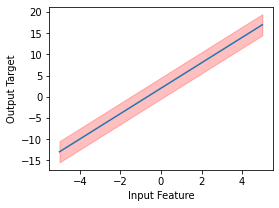

In [80]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(xs, ys_true)
ax.fill_between(xs, ys_true-threshold, ys_true+threshold, color=(1.0,0,0,.25))
ax.set_xlabel('Input Feature')
ax.set_ylabel('Output Target')

Now, pretend that instead of knowing the relatoinship between points (the blue line above), we only have some data that came from noisy measurements around that true line.

In [82]:
threshold = 2.5
xs = np.linspace(-5,5,100)
xs

array([-5.    , -4.899 , -4.798 , -4.697 , -4.596 , -4.4949, -4.3939,
       -4.2929, -4.1919, -4.0909, -3.9899, -3.8889, -3.7879, -3.6869,
       -3.5859, -3.4848, -3.3838, -3.2828, -3.1818, -3.0808, -2.9798,
       -2.8788, -2.7778, -2.6768, -2.5758, -2.4747, -2.3737, -2.2727,
       -2.1717, -2.0707, -1.9697, -1.8687, -1.7677, -1.6667, -1.5657,
       -1.4646, -1.3636, -1.2626, -1.1616, -1.0606, -0.9596, -0.8586,
       -0.7576, -0.6566, -0.5556, -0.4545, -0.3535, -0.2525, -0.1515,
       -0.0505,  0.0505,  0.1515,  0.2525,  0.3535,  0.4545,  0.5556,
        0.6566,  0.7576,  0.8586,  0.9596,  1.0606,  1.1616,  1.2626,
        1.3636,  1.4646,  1.5657,  1.6667,  1.7677,  1.8687,  1.9697,
        2.0707,  2.1717,  2.2727,  2.3737,  2.4747,  2.5758,  2.6768,
        2.7778,  2.8788,  2.9798,  3.0808,  3.1818,  3.2828,  3.3838,
        3.4848,  3.5859,  3.6869,  3.7879,  3.8889,  3.9899,  4.0909,
        4.1919,  4.2929,  4.3939,  4.4949,  4.596 ,  4.697 ,  4.798 ,
        4.899 ,  5. 

In [83]:
ys = 3 * xs + 2 + np.random.normal(0, 1.5, 100)
ys

array([-13.4914, -13.9894, -12.7812, -11.3995, -13.812 , -13.0135,
       -10.9913, -12.753 ,  -7.6581, -10.5027, -11.3302, -10.8927,
       -10.0883,  -9.9153, -11.895 ,  -6.5589,  -8.1747,  -7.8895,
        -6.3186,  -8.8243,  -8.0769,  -5.9502,  -6.4299,  -5.5129,
        -5.8474,  -5.7863,  -2.9709,  -3.2195,  -8.2633,  -1.9916,
        -0.671 ,  -1.7584,  -3.6245,  -4.0338,  -1.6052,  -3.3225,
        -1.5567,  -1.8207,   0.3422,  -1.766 ,  -1.543 ,  -0.0084,
         2.628 ,   0.1518,  -0.2914,   1.9226,   2.0166,  -0.1848,
         0.7412,   3.4933,   2.7935,  -1.25  ,   3.4805,   4.4503,
         2.1073,   4.6824,   6.7782,   4.8673,   3.6373,   4.0951,
         5.2014,   6.0515,   5.8821,   6.8433,   6.1735,   6.9679,
         8.4472,   5.7058,   7.7691,   8.0677,   9.5931,   8.1751,
         9.7978,  10.7752,   6.6495,  11.4802,   8.5522,   8.6924,
         6.3172,   9.7346,  11.2351,  10.9705,  11.1547,  10.4828,
        13.7554,  14.1952,  13.6878,  10.5338,  17.0767,  14.1

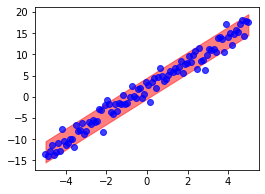

In [108]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(xs, ys, 'o', color=(0,0,1.0,.75))
ax.fill_between(xs, ys_true-threshold, ys_true+threshold,
                color=(1.0,0,0,.5))

We might consider many potential lines to fit this data.  The band around the central line captures most of the noise in the data and *throws all of those small errors* out.  The band coverage is close to perfect.  Only a few oints out of 100 are enough of a mistake to matter.  Admittedly, we cheated when drawing this data.  We based the points on the true line, which we normally do not have available.  The central line may remind you of the maximum margin separator in SVCs.

### 9.2.2 From Linear Regression to Regularized Regression to Support Vector Regression

We can develop a progression from GOF linear regression to regularized regression to support vector regresison.  At each step, we add or tweak a part of the basic recipe.  Using the `xs` and `ys` from above, we define a few terms and see the progression.  We'll image that we estimated the $w_1$ parameter to be 1.3 and we'll take $C$ = 1.0.  The threshold on the amount of error that we tolerate, also known as the band of ignorance or the band which we ignore, is $\epsilon=.25$.  That is a baby Greek *epsilon.*

In [109]:
# hyper parameters for the scenario
C, epsilon = 1.0, .25

# parameters
weights = np.array([1.3])

We can make `predictions` from that *w* and look at the three losses--square-error, absolute, and hinge losses.  We will not use the absolute loss any further, it's just there for the sake of comparison.

In [111]:
xs

array([-5.    , -4.899 , -4.798 , -4.697 , -4.596 , -4.4949, -4.3939,
       -4.2929, -4.1919, -4.0909, -3.9899, -3.8889, -3.7879, -3.6869,
       -3.5859, -3.4848, -3.3838, -3.2828, -3.1818, -3.0808, -2.9798,
       -2.8788, -2.7778, -2.6768, -2.5758, -2.4747, -2.3737, -2.2727,
       -2.1717, -2.0707, -1.9697, -1.8687, -1.7677, -1.6667, -1.5657,
       -1.4646, -1.3636, -1.2626, -1.1616, -1.0606, -0.9596, -0.8586,
       -0.7576, -0.6566, -0.5556, -0.4545, -0.3535, -0.2525, -0.1515,
       -0.0505,  0.0505,  0.1515,  0.2525,  0.3535,  0.4545,  0.5556,
        0.6566,  0.7576,  0.8586,  0.9596,  1.0606,  1.1616,  1.2626,
        1.3636,  1.4646,  1.5657,  1.6667,  1.7677,  1.8687,  1.9697,
        2.0707,  2.1717,  2.2727,  2.3737,  2.4747,  2.5758,  2.6768,
        2.7778,  2.8788,  2.9798,  3.0808,  3.1818,  3.2828,  3.3838,
        3.4848,  3.5859,  3.6869,  3.7879,  3.8889,  3.9899,  4.0909,
        4.1919,  4.2929,  4.3939,  4.4949,  4.596 ,  4.697 ,  4.798 ,
        4.899 ,  5. 

In [124]:
print(type(xs))
print(xs.ndim)
print(xs.shape)
print(xs.size)
print(xs.dtype)

<class 'numpy.ndarray'>
1
(100,)
100
float64


In [136]:
np.concatenate([xs.reshape(-1, 1)[:5],xs.reshape(-1,1)[-5:]])

array([[-5.   ],
       [-4.899],
       [-4.798],
       [-4.697],
       [-4.596],
       [ 4.596],
       [ 4.697],
       [ 4.798],
       [ 4.899],
       [ 5.   ]])

In [149]:
print(type(weights))
print(weights.ndim)
print(weights.shape)
print(weights.size)
print(weights.dtype)
weights

<class 'numpy.ndarray'>
1
(1,)
1
float64


array([1.3])

In [139]:
# prediction, error, loss
predictions = rdot(weights, xs.reshape(-1, 1))
predictions

array([-6.5   , -6.3687, -6.2374, -6.1061, -5.9747, -5.8434, -5.7121,
       -5.5808, -5.4495, -5.3182, -5.1869, -5.0556, -4.9242, -4.7929,
       -4.6616, -4.5303, -4.399 , -4.2677, -4.1364, -4.0051, -3.8737,
       -3.7424, -3.6111, -3.4798, -3.3485, -3.2172, -3.0859, -2.9545,
       -2.8232, -2.6919, -2.5606, -2.4293, -2.298 , -2.1667, -2.0354,
       -1.904 , -1.7727, -1.6414, -1.5101, -1.3788, -1.2475, -1.1162,
       -0.9848, -0.8535, -0.7222, -0.5909, -0.4596, -0.3283, -0.197 ,
       -0.0657,  0.0657,  0.197 ,  0.3283,  0.4596,  0.5909,  0.7222,
        0.8535,  0.9848,  1.1162,  1.2475,  1.3788,  1.5101,  1.6414,
        1.7727,  1.904 ,  2.0354,  2.1667,  2.298 ,  2.4293,  2.5606,
        2.6919,  2.8232,  2.9545,  3.0859,  3.2172,  3.3485,  3.4798,
        3.6111,  3.7424,  3.8737,  4.0051,  4.1364,  4.2677,  4.399 ,
        4.5303,  4.6616,  4.7929,  4.9242,  5.0556,  5.1869,  5.3182,
        5.4495,  5.5808,  5.7121,  5.8434,  5.9747,  6.1061,  6.2374,
        6.3687,  6.5

In [144]:
print(type(ys))
print(ys.ndim)
print(ys.shape)
print(ys.size)
print(ys.dtype)
ys

<class 'numpy.ndarray'>
1
(100,)
100
float64


array([-13.4914, -13.9894, -12.7812, -11.3995, -13.812 , -13.0135,
       -10.9913, -12.753 ,  -7.6581, -10.5027, -11.3302, -10.8927,
       -10.0883,  -9.9153, -11.895 ,  -6.5589,  -8.1747,  -7.8895,
        -6.3186,  -8.8243,  -8.0769,  -5.9502,  -6.4299,  -5.5129,
        -5.8474,  -5.7863,  -2.9709,  -3.2195,  -8.2633,  -1.9916,
        -0.671 ,  -1.7584,  -3.6245,  -4.0338,  -1.6052,  -3.3225,
        -1.5567,  -1.8207,   0.3422,  -1.766 ,  -1.543 ,  -0.0084,
         2.628 ,   0.1518,  -0.2914,   1.9226,   2.0166,  -0.1848,
         0.7412,   3.4933,   2.7935,  -1.25  ,   3.4805,   4.4503,
         2.1073,   4.6824,   6.7782,   4.8673,   3.6373,   4.0951,
         5.2014,   6.0515,   5.8821,   6.8433,   6.1735,   6.9679,
         8.4472,   5.7058,   7.7691,   8.0677,   9.5931,   8.1751,
         9.7978,  10.7752,   6.6495,  11.4802,   8.5522,   8.6924,
         6.3172,   9.7346,  11.2351,  10.9705,  11.1547,  10.4828,
        13.7554,  14.1952,  13.6878,  10.5338,  17.0767,  14.1

In [145]:
errors = ys - predictions

In [147]:
print(type(errors))
print(errors.ndim)
print(errors.shape)
print(errors.size)
print(errors.dtype)
errors

<class 'numpy.ndarray'>
1
(100,)
100
float64


array([-6.9914, -7.6207, -6.5438, -5.2934, -7.8372, -7.17  , -5.2792,
       -7.1721, -2.2086, -5.1846, -6.1433, -5.8371, -5.1641, -5.1224,
       -7.2334, -2.0286, -3.7758, -3.6219, -2.1823, -4.8193, -4.2031,
       -2.2078, -2.8188, -2.0332, -2.4989, -2.5691,  0.1149, -0.2649,
       -5.4401,  0.7003,  1.8896,  0.6709, -1.3265, -1.8671,  0.4301,
       -1.4185,  0.2161, -0.1793,  1.8523, -0.3872, -0.2955,  1.1077,
        3.6129,  1.0053,  0.4309,  2.5135,  2.4762,  0.1435,  0.9382,
        3.5589,  2.7279, -1.447 ,  3.1523,  3.9907,  1.5164,  3.9602,
        5.9246,  3.8824,  2.5212,  2.8476,  3.8226,  4.5414,  4.2407,
        5.0706,  4.2695,  4.9326,  6.2805,  3.4078,  5.3398,  5.5071,
        6.9012,  5.3518,  6.8432,  7.6894,  3.4324,  8.1317,  5.0724,
        5.0813,  2.5748,  5.8609,  7.2301,  6.8341,  6.887 ,  6.0838,
        9.2251,  9.5336,  8.8949,  5.6096, 12.0211,  9.0033,  9.764 ,
        6.8788,  9.2808, 10.0897,  9.4301, 11.1214, 11.9354,  8.1413,
       11.6035, 11.0

In [153]:
loss_sse = np.sum(errors ** 2)
loss_sae = np.sum(np.abs(errors))
loss_hinge = np.sum(np.max(np.abs(errors) - epsilon, 0))

Also, we can compute the two complexity penalties we need for $L_1$ and $L_2$ regularization.  Note the close similarity to the calculations for the *losses*, except we calculate the complexity from the *weights* instead of the *errors*.

In [154]:
# complexity penalty for regularization
complexity_saw = np.sum(np.abs(weights))
complexity_ssw = np.sum(weights**2)
print(complexity_saw)
print(complexity_ssw)

1.3
1.6900000000000002


Finally, we can calculate our total costs.

In [157]:
cost_gof_regression   = loss_sse + 0.0
cost_L1pen_regression = loss_sse + C * complexity_saw
cost_L2pen_regression = loss_sse + C * complexity_ssw
cost_sv_regression    = loss_hinge + C * complexity_ssw
print(cost_gof_regression)
print(cost_L1pen_regression)
print(cost_L2pen_regression)
print(cost_sv_regression)

3179.7823768670883
3181.0823768670884
3181.4723768670883
13.461128848137333


The code above only calculates a cost for each type of regression for *one* set of weights.  We would have to run that code over and over--with different sets of weights--to find a good, better, or best set of weights.

The table below shows the math forms buried in the code.  If we let $ L_1 = \Sigma \big | v_i \big | $ and $ L_2 = \Sigma v_i^2 $.

The loss applies to raw errors and the penalty applies to the parameters or weights.

In reality, we **don't know the right assumptions to choose between learning methods.**  The discrimnant methods or these varied regression methods.  Therefore, we do not know whether the noise and underlying complexity of data is going to be best suited to one or another of these technqiues.  We *can* cross-validate the data to pick a preferred method for a given dataset.  

The choice between models may depend on outside constraints.  On very complex problems, we might not even bother with GOF linear regression, although it might make a good baseline comparison.  If we have a lot of features, we may choose the lasso--$L_1$-penalized--to eliminate features entirely.  Ridge, on the other hand, has a more moderate approach and only reduces, but does not eliminate, features.

| **Name** | **Penalty** | **Math** |
| :--- | :--- | :---: |
| GOF Linear Regression | None | $$ \Sigma_i (y_i - wx_{i})^2 $$ |
| Lasso | $ L_1 $ | $$ \Sigma_i(y_i - wx_i)^2 + C\Sigma_{j}\big|w_j\big| $$  |
| Ridge | $ L_2 $ | $$ \Sigma_i(y_i - wx_i)^2 + C\Sigma_{j}w_j^2 $$ |
| SVR | $ L_1 $ | $$ \Sigma_i(\big|y_i - wx_i \big| - \epsilon, 0) + C \Sigma_j w_j $$ |

| **Name** | **Loss** | **Penalty** |
| :--- | :--- | :--- |
| GOF Linear Regression | $L_1$ | 0 |
| Lasso ($L_1$-Penalty LR) | $L_2$ | $L_1$  |
| Ridge ($L_2$-Penalty LR)| $L_2$ | $L_2$ |
| SVR | Hinge | $L_1$ |


## 9.2.3 SVR Implementation

There are two main options for SVR in `sklearn`.  You can control different aspects with these two regressors.

1. $\epsilon$-SVR: you set the error band tolerance. $\nu$ is determined implicitly by this choice.  This is what you get with the default parameters to `SVR` in `sklearn`.
2. $\nu$-SVR: you set $\nu$, the proportion of kept support vectors with respect to teh total number of examples.  $\epsilon$, the error band tolerance, is determined implicitly by this choice.

In [159]:
svrs = [svm.SVR(),    # default epsilon=0.1
        svm.NuSVR()]  # default nu=0.5

for model in svrs:
    preds = (model.fit(diabetes_train_ftrs, diabetes_train_tgt)
                  .predict(diabetes_test_ftrs))
    print(metrics.mean_squared_error(diabetes_test_tgt, preds))

4511.861877534951
4608.838803768554


# 9.3 Piecewise Constant Regression

All linear regression techniques we looked at have one common theme: they assume that a suitably small variation of the inputs leads to a small variation in the output.  This is related to the concept of *smoothness*.  The output never jumps around.  In classificaiton, we *expect* the outputs to make leaps: at some critical point we move from predicted *dog* to predicting *cat*. Methods like logistic regression have smooth transitions from one class to the next; decision tree classifiers are distinctly dog-or-cat.  In mathese, if we have a numerical output value that is not sufficiently smooth, we say we have a *discontinuous target*.

Let's look at a concrete example.  Suppose a hotdog stand wants to be cash-only and does not want to deal with coins.  They are *literally* paper-cash only .  Therefore, if a customer gets a bill of $2.75, the round up and charge the customer $3.00.  Here's a graph that converts the raw bill to a collected bill.

In [168]:
raw_bill = np.linspace(.5, 10.0, 100)
print(np.concatenate([raw_bill[:5].reshape(-1,1), raw_bill[-5:].reshape(-1,1)]))
print(raw_bill)


[[ 0.5   ]
 [ 0.596 ]
 [ 0.6919]
 [ 0.7879]
 [ 0.8838]
 [ 9.6162]
 [ 9.7121]
 [ 9.8081]
 [ 9.904 ]
 [10.    ]]
[ 0.5     0.596   0.6919  0.7879  0.8838  0.9798  1.0758  1.1717  1.2677
  1.3636  1.4596  1.5556  1.6515  1.7475  1.8434  1.9394  2.0354  2.1313
  2.2273  2.3232  2.4192  2.5152  2.6111  2.7071  2.803   2.899   2.9949
  3.0909  3.1869  3.2828  3.3788  3.4747  3.5707  3.6667  3.7626  3.8586
  3.9545  4.0505  4.1465  4.2424  4.3384  4.4343  4.5303  4.6263  4.7222
  4.8182  4.9141  5.0101  5.1061  5.202   5.298   5.3939  5.4899  5.5859
  5.6818  5.7778  5.8737  5.9697  6.0657  6.1616  6.2576  6.3535  6.4495
  6.5455  6.6414  6.7374  6.8333  6.9293  7.0253  7.1212  7.2172  7.3131
  7.4091  7.5051  7.601   7.697   7.7929  7.8889  7.9848  8.0808  8.1768
  8.2727  8.3687  8.4646  8.5606  8.6566  8.7525  8.8485  8.9444  9.0404
  9.1364  9.2323  9.3283  9.4242  9.5202  9.6162  9.7121  9.8081  9.904
 10.    ]


In [169]:
collected = np.round(raw_bill)
collected

array([ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
        9.,  9.,  9., 10., 10., 10., 10., 10., 10.])

Text(0, 0.5, 'bill')

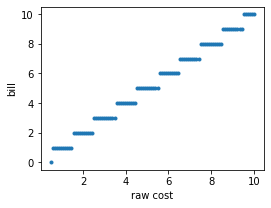

In [170]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(raw_bill, collected, '.')
ax.set_xlabel('raw cost')
ax.set_ylabel('bill')

The graph looks like a set of stairs and it is not possible for a smooth regression line to capture this pattern in the relationship.  A single line through the dataset will have problems.  To put it bluntly, the bias of linear regression puts a fundamental limit on our ability to follow the pattern.

We could use decision trees to break down the inputs into little buckets.  We will look at that soon.  First, we will examine a middle ground between using linear regression and modifying decision trees to perform regression.  We will use *piecewise* linear regression in the simplest way: *piecewise constant regression.* For each region of the input features, we predict a simple horizontal line.  This means that we predict a single constant value for that region.

The cost-versus-bill graph is one example where this is an appropriate model.  Let's develop an example with a less consistent relationship.  Instead of constantly working our way up, we move both up and down as *x* increases.  Let's define some split points.  Therefore, if we want four lines, we define three split points.  Imagine splitting at *a, b* and *c*.  Then, we fit four lines on the data: (1) from very small up to *a*, (2) from *a* to *b*, (3) from *b* to *c*, and (4) from *c* onwards to very big.  `a,b,c,=3,8,12`.  The results might look like the following:

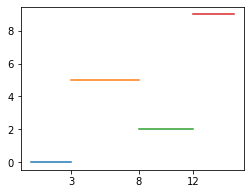

In [173]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot([0,3],     [0,0],
        [3,8],     [5,5],
        [8,12],    [2,2],
        [12,15],   [9,9])
ax.set_xticks([3,8,12])

If there are no splits, we simply perform linear regression without a close and predict a constant value everywhere using the mean.  If we go to th eother extreme, where we have *n* data points and make *n*-1 mini-lines the model will do great in training, but will do bad in texting because it overfits the data.

In some ways, piecewise constant regression is like *k*-Nearest Neighbors Regression (*k*-NN-R).  However, *k*-NN-R considers examples based on relative distance instead of raw numeric value.  For example, we claim a new testing example is like examples 3, 17, or 21 because they are close to the new example, regardless of the raw numeric value.  Piecewise constant regression gives examples the same target value based on a preset range of splits: If my value is 6, I am like the examples with values between 5 and 10 even if I'm closer to an example with value 4.

With *k*-NN-R the data determines the boundary between predictions *and* those boundaries move with the density of the data.  Denser regions get more potential boundaries.  With piecewise constant regression, our splits are predetermined.  We have no wiggle room for areas with high or low densities of data.  The net effect is that we may do very well when choosing splits for piece wise regression if we have some strong background information about the data.  For example, in the US, tax brackets are set by predetermined break points.  If we don't ahve the right informatoin, our splits may do much worse than *k*-NN-R.

## 9.3.1 Implementing a Piecewise Constant Regressor

`sklearn` does not have a built-in piecewise regression model.  Therefore, we will implement a learner of our own.  It is about 40 lines of code and makes use of two main ideas.  

1. To perform each constant regression for the individual pieces, we simply reuse `sklearn`'s built-in linear regression on a rewritten form of the data.
2. We need to map from the input feature--we limit ourself to just one for now--to the appropriate section of our rope. The mapping has two steps:
    1. In the first step we use `np.searchsorted`. `searchsorted` finds an insertion point for a new element into a sorted sequence of values.
        1. It says where someone should enter a line of people ordered by height to maintain the ordering.
        2. We want to be able to translate a feature value of 60 to segment, or rope piece, 3.
        3. We do this in both the training and testing phases.
    2. We convert the rope pieces to true/false indicators.
        1. Instead of $Piece = 3$, we have $Piece_1 = False$, $Piece_2 = False$, $Piece_3 = True$.
        2. Then, we learn a regression model from the piece indicators to the output target.
            1. When we want to predict a new example, we run it through the mapping process to get the right piece indicator and then pipe it to the constant linear regression.
            2. The remapping is wrapped up in the `_recode` member function in the code below.
            
## 9.3.2 General Notes on Implementing Models

The following is a simplified process for implementing custom models in `sklearn`.

* We will inherit from `BaseEstimator` and `RegressorMixin` because we are implementing a regressor
* We will *not* do anything with the model arguments in `__init__`.
* We define `fit(X,y)` and `predict(X)` methods.
* We make use of `check_X_y` and `check_array` to verify arguments are valid in the `sklearn` sense.

Quick code comments:

* The following code only works for a single feature.  Chapter 10 includes ideas on how to extend the code to multiple features.
* If no cut points are defined, we use one cut point for every ten examples and we choose the cut points at evenly spaced percentiles of the data.
    * For two regions, the split point would be at 50%, or the median.  With three or four regions, the splits would be at 33-67% or 25-50-75%. Ironically, a single split at 50% might be bad if the data is concentrated in the middle, as might be the case with heights.
    

In [203]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import (check_X_y,
                                      check_array,
                                      check_is_fitted)

class PiecewiseConstantRegression(BaseEstimator, RegressorMixin):
    def __init__(self, cut_points=None):
        self.cut_points = cut_points
        
    def fit(self, X, y):
        X, y = check_X_y(X,y)
        assert X.shape[1] == 1 # one variable only
        
        if self.cut_points is None:
            n = (len(X) // 10) + 1
            qtiles = np.linspace(0.0, 1.0, n+2)[1:-1]
            self.cut_points = np.percentile(X, qtiles, axis=1)
        else:
            # ensure cutpoints in order and in range of X
            assert np.all(self.cut_points[:-1] < self.cut_points[1:])
            assert (X.min() < self.cut_points[0] and
                    self.cut_points[-1] < X.max())
            
        recoded_X = self._recode(X)
        # even though the _inner_ model is fit without an intercept,
        # our piecewise model *does* have a constant term (but see notes)
        self.coeffs_ = (linear_model.LinearRegression(fit_intercept=False)
                                    .fit(recoded_X, y).coef_)
        
    def _recode(self, X):
        cp = self.cut_points
        n_pieces = len(cp) + 1
        recoded_X = np.eye(n_pieces)[np.searchsorted(cp, X.flat)]
        return recoded_X
    
    def predict(self, X):
        check_is_fitted(self, 'coeffs_')
        X = check_array(X)
        recoded_X = self._recode(X)
        return rdot(self.coeffs_, recoded_X)    

To test and demonstrate that code, let's generate a simple example dataset we can train on.

In [187]:
ftr = np.random.randint(0,10,(100,1)).astype(np.float64)

print(f'Dimensions: {ftr.ndim}')
print(f'Shape: {ftr.shape}')
print(f'Size: {ftr.size}')
print(f'DataType: {ftr.dtype}')
print(f'Examples:\n{np.concatenate([ftr[:5],ftr[-5:]])}')

Dimensions: 2
Shape: (100, 1)
Size: 100
DataType: float64
Examples:
[[1.]
 [4.]
 [9.]
 [3.]
 [8.]
 [6.]
 [4.]
 [5.]
 [5.]
 [7.]]


In [191]:
cp = np.array([3,7])
tgt = np.searchsorted(cp, ftr.flat) + 1

In [195]:
print(f'Dimensions: {tgt.ndim}')
print(f'Shape: {tgt.shape}')
print(f'Size: {tgt.size}')
print(f'DataType: {tgt.dtype}')
print(f'Examples:\n{np.concatenate([tgt[:5],tgt[-5:]])}')
print(tgt)

Dimensions: 1
Shape: (100,)
Size: 100
DataType: int64
Examples:
[1 2 3 1 3 2 2 2 2 2]
[1 2 3 1 3 2 1 1 2 3 2 3 2 2 3 2 2 3 2 2 1 3 2 2 3 1 3 2 3 1 2 1 1 2 1 1 3
 2 2 1 1 2 2 1 2 1 2 2 2 2 2 2 1 3 1 1 1 1 1 1 1 3 3 1 2 3 3 2 1 1 3 2 3 3
 2 1 1 1 2 1 2 1 1 2 1 1 3 3 2 1 2 1 2 2 1 2 2 2 2 2]


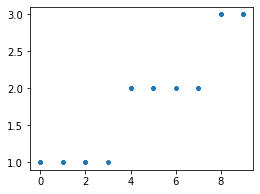

In [196]:
fig, ax  = plt.subplots(1,1,figsize=(4,3))
ax.plot(ftr, tgt, '.')

Our use of the code is familiar because we created a learner that directly uses the `sklearn` API.

In [204]:
# here, we're giving ourselves all the help we can by using
# the same cut points as our data were generated with
model = PiecewiseConstantRegression(cut_points=np.array([3, 7]))
model.fit(ftr, tgt)
preds = model.predict(ftr)
print("predictions equal target?", np.allclose(preds, tgt))


predictions equal target? True


`PiecewiseConstantRegression` is defined by some hyperparameters (the cut points) and some parameters (the constants associated with each piece).  The constants are computed when we call `fit`.  The overall fit of the model is very, very sensitive to the number and location of the split points.  If we are thinking about using piecewise methods, we either (1) hope to have background knowledge about where the jumps are or (2) are willing to spend time trying different hyper parameters and cross-validating the results to get a good end product.

We could extend this to piecewise lines, piecewise parabolas, etc.  We could also require that the end points meet.  This requirement gets us a degree of continuity, but not necessarily smoothness.  We could connect the piecewise segments but there migth still be sharp turns.  We could enforce an even higher degree of smoothness where the turns have to be more gentle.  Allowing more bends in the piecewise components reduces our bias.  Enforcing constraints on the meeting oints smooths the model.

# 9.4 Regression Trees

Decision trees find regions with similar outputs and label everything in that region in some way.  If we can find regions where a single numerical value is a good representation of the whole region, we're golden.  At the leaves of the tree, instead of saying *cat* or *dog*, we say 37.5.

## 9.4.1 Performing Regression with Trees

It is a straighforward concept to move from piecewise constant regression to decision trees beccause decision trees gives us a way to zoom in on regions that are similar and, having selected a region, predict a constant.  The zoom-in happens as we segment off regions of space.

Eventually, we get to a small enough region that behaves in a nicely uniform way.  Using decision trees for regression gives us an automatic way to pick the number and location of split poitns.  The splits are determined by computing the loss when a split breaks the current set of data at a node into two subsets.  The split that leads to the immediate lowest squared error is the chosen breakpoint for that node.  Tree building is a greedy process and it is not guaranteed to be a globally best step, but a sequence of greedy steps is often good enough for day-to-day use.

In [205]:
dtrees = [tree.DecisionTreeRegressor(max_depth=md) for md in [1, 3, 5, 10]]

for model in dtrees:
    preds = (model.fit(diabetes_train_ftrs, diabetes_train_tgt)
                  .predict(diabetes_test_ftrs))
    mse = metrics.mean_squared_error(diabetes_test_tgt, preds)
    fmt = '{} {:2d} {:4.0f}'
    print(fmt.format(get_model_name(model),
                     model.get_params()['max_depth'],
                     mse))

DecisionTreeRegressor  1 4341
DecisionTreeRegressor  3 3593
DecisionTreeRegressor  5 4018
DecisionTreeRegressor 10 5520


Notice how adding depth helps and then hurts.  This is because of *overfitting!*.  If we allow too much depth, we split the data into too many parts.  If the data is split too finely, we make unneeded distinctions, we overfit, and our test error creeps up.

# Comparison of Regressors: Take Three

We return to the student dataset and apply some of our fancier learners to it.

In [206]:
student_url = ('https://archive.ics.uci.edu/' + 
               'ml/machine-learning-databases/00320/student.zip')

def grab_student_numeric():
    # download zip file and unzip
    # unzipping unknown files can be a security hazard
    import urllib.request, zipfile
    urllib.request.urlretrieve(student_url,
                               'port_student.zip')
    zipfile.ZipFile('port_student.zip').extract('student-mat.csv')
    
    # preprocessing
    df = pd.read_csv('student-mat.csv', sep=';')
    
    # g1 & g2 are highly correlated with g3;
    # dropping them makes the problem significanltty harder
    # we also remove all non-numeric columns
    df = df.drop(columns=['G1', 'G2']).select_dtypes(include=['number'])
    
    # save as
    df.to_csv('portugese_student_numeric.csv', index=False)
    

grab_student_numeric()


In [207]:
student_df = pd.read_csv('portugese_student_numeric.csv')
student_ftrs = student_df[student_df.columns[:-1]]
student_tgt = student_df['G3']

In [208]:
student_tts = skms.train_test_split(student_ftrs, student_tgt)

(student_train_ftrs, student_test_ftrs,
 student_train_tgt,  student_test_tgt) = student_tts

We bring in the regression methods introduced in Chapter 7.

In [209]:
old_school = [linear_model.LinearRegression(),
              neighbors.KNeighborsRegressor(n_neighbors=3),
              neighbors.KNeighborsRegressor(n_neighbors=10)]

And add some new regressors from this chapter:

In [210]:
# L1, L2 penalized (abs, sqr), C=1.0 for both
penalized_lr = [linear_model.Lasso(),
                linear_model.Ridge()]

#defaults are epsilon=.1 and nu=.5, respectively
svrs = [svm.SVR(), svm.NuSVR()]

dtrees = [tree.DecisionTreeRegressor(max_depth=md) for md in [1, 3, 5, 10]]

reg_models = old_school + penalized_lr + svrs + dtrees

Let's compare these methods based on root mean squared error (RMSE):

In [211]:
def rms_error(actual, predicted):
    ' root-mean-squared-error function'
    # lesser values are better (a<b means a is better)
    mse = metrics.mean_squared_error(actual, predicted)
    return np.sqrt(mse)
rms_scorer = metrics.make_scorer(rms_error)

and we standardize the data before we aplpy the models.

In [212]:
scaler = skpre.StandardScaler()

scores = {}
for model in reg_models:
    pipe = pipeline.make_pipeline(scaler, model)
    preds = skms.cross_val_predict(pipe,
                                   student_ftrs, student_tgt,
                                   cv=10)
    key = (get_model_name(model) +
           str(model.get_params().get('max_depth', '')) +
           str(model.get_params().get('n_neighbors', '')))
    scores[key] = rms_error(student_tgt, preds)
    
df = pd.DataFrame.from_dict(scores, orient='index').sort_values(0)
df.columns=['RMSE']
df

,RMSE
DecisionTreeRegressor1,4.3192
Ridge,4.3646
LinearRegression,4.3653
NuSVR,4.3896
SVR,4.4062
DecisionTreeRegressor3,4.4298
Lasso,4.4375
KNeighborsRegressor10,4.4873
DecisionTreeRegressor5,4.7074
KNeighborsRegressor3,4.8915


For the top four models, let's look at some details about performance on a fold-by-fold basis.

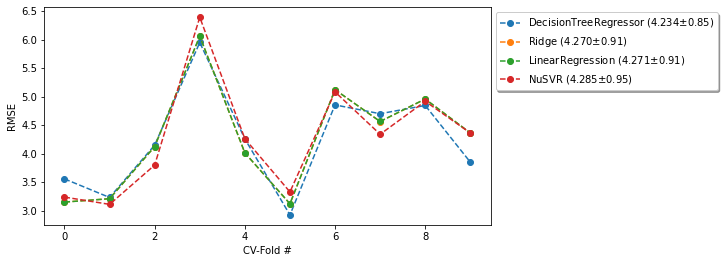

In [225]:
better_models = [tree.DecisionTreeRegressor(max_depth=1),
                 linear_model.Ridge(),
                 linear_model.LinearRegression(),
                 svm.NuSVR()]
fig, ax = plt.subplots(1, 1, figsize=(8,4))
for model in better_models:
    pipe = pipeline.make_pipeline(scaler, model)
    cv_results = skms.cross_val_score(pipe, 
                                      student_ftrs, student_tgt,
                                      scoring = rms_scorer,
                                      cv=10)
    my_lbl = '{:s} ({:5.3f}$\pm${:.2f})'.format(get_model_name(model),
                                               cv_results.mean(),
                                               cv_results.std())
    
    ax.plot(cv_results, 'o--', label=my_lbl)
    ax.set_xlabel('CV-Fold #')
    ax.set_ylabel('RMSE')
    ax.legend(bbox_to_anchor=(1.00, 1.00), fancybox=True, shadow=True)

Each goes back and forth a bit.  They are all very close in learning performance.  The range of the means (4.23, 4.29) is not very wide and it's also a bit less than the standard deviation.  There's more work to be done.  We didn't actually work through different values for regularization.  We can do that by hand, in a manner similar to the complexity curves we saw earlier.   However, we appraoch it in a much more convenient fashion in Section 11.2.

# New version

In [21]:
from sklearn.datasets import load_boston
#load data as a bunch object (bo)
boston_bo = load_boston()
print(f'Loading boston dataset...')
print(f'Type dataset object: {type(boston_bo)}')
print(f'Dataset keys: {boston_bo.keys()}')
print(f'Description: {boston_bo.DESCR}')
import pandas as pd

# convert to dataframe object
boston_df = pd.DataFrame(boston_bo.data, columns=boston_bo.feature_names)
# add target column
boston_df['MEDV'] = boston_bo.target
rows, cols = boston_df.shape
print(f'Dataset rows: {rows}')
print(f'Dataset cols: {cols} ({cols-1} features and 1 target variable)')
print(f'Total elements in dataset: {boston_df.size}')

Loading boston dataset...
Type dataset object: <class 'sklearn.utils.Bunch'>
Dataset keys: dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
Description: .. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to f

In [22]:
print(boston_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB
None


In [25]:
# split data into test and validation datasets
from sklearn.model_selection import train_test_split

boston_ftrs = boston_df[boston_df.columns[:-1]]
boston_tgt = boston_df['MEDV']
boston_tts = train_test_split(boston_ftrs, boston_tgt)
(boston_train_ftrs, boston_test_ftrs,
 boston_train_tgt,  boston_test_tgt) = boston_tts
print('Split the data into training and test features:' )
print(f'Training Features: {boston_train_ftrs.shape}')
print(f'Training Target: {boston_train_tgt.shape}')
print(f'Testing Features: {boston_test_ftrs.shape}')
print(f'Testing Target: {boston_test_tgt.shape}')

Split the data into training and test features:
Training Features: (379, 13)
Training Target: (379,)
Testing Features: (127, 13)
Testing Target: (127,)
